<a href="https://colab.research.google.com/github/Mith-Jain/AI-Choreography/blob/main/GNN_for_Spatial_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric

In [ ]:
!pip install networkx

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
motion_data  = pickle.load(open("/content/drive/MyDrive/edge_aistpp/motions/gBR_sBM_cAll_d04_mBR0_ch04.pkl","rb"))
motion_data

{'smpl_loss': 1.9804539680480957,
 'smpl_poses': array([[-2.5402021e-01,  1.0790447e+00, -3.2611117e-01, ...,
          2.1950207e-03, -3.4160182e-04,  6.5241829e-03],
        [-2.5178561e-01,  1.0909940e+00, -3.3540604e-01, ...,
          1.8025528e-03, -5.6651892e-04,  5.9106024e-03],
        [-2.4517223e-01,  1.1230410e+00, -3.4188884e-01, ...,
          1.0666245e-03, -1.0431040e-03,  5.4379208e-03],
        ...,
        [ 1.6730228e-01, -9.1729444e-01,  5.8604013e-02, ...,
         -2.1016370e-03, -4.3079001e-03,  1.2162547e-03],
        [ 1.7439316e-01, -9.0081340e-01,  5.4894302e-02, ...,
         -2.2951544e-03, -3.9827581e-03,  5.0095358e-04],
        [ 1.7330101e-01, -8.8698792e-01,  5.8664370e-02, ...,
         -2.7542312e-03, -3.3169615e-03,  6.5153225e-05]], dtype=float32),
 'smpl_scaling': array([94.51005], dtype=float32),
 'smpl_trans': array([[-28.042538 , 183.04108  , -12.137114 ],
        [-28.21238  , 183.0978   , -12.055348 ],
        [-28.408918 , 183.07715  , -11.

In [ ]:
!pip install torch_geometric_temporal

  Using cached torch_geometric_temporal-0.54.0-py3-none-any.whl
  Using cached pandas-1.3.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.5 MB)
  Using cached torch_sparse-0.6.17.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_scatter-2.1.1-cp310-cp310-linux_x86_64.whl
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 79, in main
    return command.main(cmd_args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 100, in main
    with self.main_context():
  File "/usr/lib/python3.10/contextlib.py", line 142, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/command_context.py", line 19, in main_context
    with self._main_context:
  File "/usr/lib/python3.10/contextlib.py", line 576, in 

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import ChebConv


class TemporalConv(nn.Module):
    r"""Temporal convolution block applied to nodes in the STGCN Layer
    For details see: `"Spatio-Temporal Graph Convolutional Networks:
    A Deep Learning Framework for Traffic Forecasting."
    <https://arxiv.org/abs/1709.04875>`_ Based off the temporal convolution
     introduced in "Convolutional Sequence to Sequence Learning"  <https://arxiv.org/abs/1709.04875>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3):
        super(TemporalConv, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv_2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv_3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """Forward pass through temporal convolution block.

        Arg types:
            * **X** (torch.FloatTensor) -  Input data of shape
                (batch_size, input_time_steps, num_nodes, in_channels).

        Return types:
            * **H** (torch.FloatTensor) - Output data of shape
                (batch_size, in_channels, num_nodes, input_time_steps).
        """
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = H.permute(0, 3, 2, 1)
        return H


class STConv(nn.Module):
    r"""Spatio-temporal convolution block using ChebConv Graph Convolutions.
    For details see: `"Spatio-Temporal Graph Convolutional Networks:
    A Deep Learning Framework for Traffic Forecasting"
    <https://arxiv.org/abs/1709.04875>`_

    NB. The ST-Conv block contains two temporal convolutions (TemporalConv)
    with kernel size k. Hence for an input sequence of length m,
    the output sequence will be length m-2(k-1).

    Args:
        in_channels (int): Number of input features.
        hidden_channels (int): Number of hidden units output by graph convolution block
        out_channels (int): Number of output features.
        kernel_size (int): Size of the kernel considered.
        K (int): Chebyshev filter size :math:`K`.
        normalization (str, optional): The normalization scheme for the graph
            Laplacian (default: :obj:`"sym"`):

            1. :obj:`None`: No normalization
            :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`

            2. :obj:`"sym"`: Symmetric normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
            \mathbf{D}^{-1/2}`

            3. :obj:`"rw"`: Random-walk normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1} \mathbf{A}`

            You need to pass :obj:`lambda_max` to the :meth:`forward` method of
            this operator in case the normalization is non-symmetric.
            :obj:`\lambda_max` should be a :class:`torch.Tensor` of size
            :obj:`[num_graphs]` in a mini-batch scenario and a
            scalar/zero-dimensional tensor when operating on single graphs.
            You can pre-compute :obj:`lambda_max` via the
            :class:`torch_geometric.transforms.LaplacianLambdaMax` transform.
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)

    """

    def __init__(
        self,
        num_nodes: int,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        kernel_size: int,
        K: int,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(STConv, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.K = K
        self.normalization = normalization
        self.bias = bias

        self._temporal_conv1 = TemporalConv(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
        )

        self._graph_conv = ChebConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            K=K,
            normalization=normalization,
            bias=bias,
        )

        self._temporal_conv2 = TemporalConv(
            in_channels=hidden_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
        )

        self._batch_norm = nn.BatchNorm2d(num_nodes)

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
    ) -> torch.FloatTensor:

        r"""Forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph.

        Arg types:
            * **X** (PyTorch FloatTensor) - Sequence of node features of shape (Batch size X Input time steps X Num nodes X In channels).
            * **edge_index** (PyTorch LongTensor) - Graph edge indices.
            * **edge_weight** (PyTorch LongTensor, optional)- Edge weight vector.

        Return types:
            * **T** (PyTorch FloatTensor) - Sequence of node features.
        """
        T_0 = self._temporal_conv1(X)
        T = torch.zeros_like(T_0).to(T_0.device)
        for b in range(T_0.size(0)):
            for t in range(T_0.size(1)):
                T[b][t] = self._graph_conv(T_0[b][t], edge_index, edge_weight)

        T = F.relu(T)
        T = self._temporal_conv2(T)
        T = T.permute(0, 2, 1, 3)
        T = self._batch_norm(T)
        T = T.permute(0, 2, 1, 3)
        return T

We will get the data of 1 frame out of the 720 frames

In [ ]:
motion_data['smpl_poses'][0:10].shape

(10, 72)

In [ ]:
total_data = np.array(motion_data['smpl_poses'][:10]).reshape((1, 10, 24, 3))
total_data[0][0]
total_data = torch.tensor(total_data, dtype = torch.float)
total_data[0][0]

tensor([[-2.5402e-01,  1.0790e+00, -3.2611e-01],
        [-7.5377e-02, -1.1440e-02,  3.9088e-01],
        [-8.8694e-01,  2.8769e-01, -1.8023e-01],
        [ 1.4145e-01, -6.8148e-02,  2.8037e-01],
        [ 2.1015e-01,  8.2510e-03, -9.4474e-03],
        [ 1.2557e+00, -3.1012e-02,  8.1020e-01],
        [ 2.3121e-01, -2.1422e-02,  5.5015e-03],
        [ 7.5530e-04,  5.9645e-03, -8.2161e-03],
        [ 1.7023e-03, -2.8756e-03, -2.2088e-03],
        [ 2.9547e-01, -9.2897e-03, -8.3168e-02],
        [ 1.2540e-04,  3.7024e-03,  6.7848e-03],
        [ 2.2001e-03,  7.4864e-03,  3.7359e-03],
        [ 1.7494e-02, -2.1532e-01,  3.5900e-03],
        [-5.4418e-02, -4.3293e-01,  3.4054e-02],
        [-1.3944e-01,  4.5678e-01, -2.0616e-01],
        [-2.3710e-01, -3.6145e-01,  2.7604e-01],
        [-1.2006e-01, -8.8270e-01, -7.4800e-01],
        [-9.1023e-02,  7.1990e-01,  2.2854e-01],
        [-1.1614e-01, -1.8250e+00,  5.1953e-01],
        [-6.4241e-02,  1.7547e+00, -4.1716e-01],
        [ 6.3233e-03

We will now reshape our data to (num of nodes, num of features) because the graph will take in data in this format. I have assumed that 3 consecutive values represent one node.

In [ ]:
frame_data = np.array(motion_data['smpl_poses'][0])
frame_data = frame_data.reshape((24, 3))
frame_data = torch.tensor(frame_data, dtype = torch.float)
frame_data

tensor([[-2.5402e-01,  1.0790e+00, -3.2611e-01],
        [-7.5377e-02, -1.1440e-02,  3.9088e-01],
        [-8.8694e-01,  2.8769e-01, -1.8023e-01],
        [ 1.4145e-01, -6.8148e-02,  2.8037e-01],
        [ 2.1015e-01,  8.2510e-03, -9.4474e-03],
        [ 1.2557e+00, -3.1012e-02,  8.1020e-01],
        [ 2.3121e-01, -2.1422e-02,  5.5015e-03],
        [ 7.5530e-04,  5.9645e-03, -8.2161e-03],
        [ 1.7023e-03, -2.8756e-03, -2.2088e-03],
        [ 2.9547e-01, -9.2897e-03, -8.3168e-02],
        [ 1.2540e-04,  3.7024e-03,  6.7848e-03],
        [ 2.2001e-03,  7.4864e-03,  3.7359e-03],
        [ 1.7494e-02, -2.1532e-01,  3.5900e-03],
        [-5.4418e-02, -4.3293e-01,  3.4054e-02],
        [-1.3944e-01,  4.5678e-01, -2.0616e-01],
        [-2.3710e-01, -3.6145e-01,  2.7604e-01],
        [-1.2006e-01, -8.8270e-01, -7.4800e-01],
        [-9.1023e-02,  7.1990e-01,  2.2854e-01],
        [-1.1614e-01, -1.8250e+00,  5.1953e-01],
        [-6.4241e-02,  1.7547e+00, -4.1716e-01],
        [ 6.3233e-03

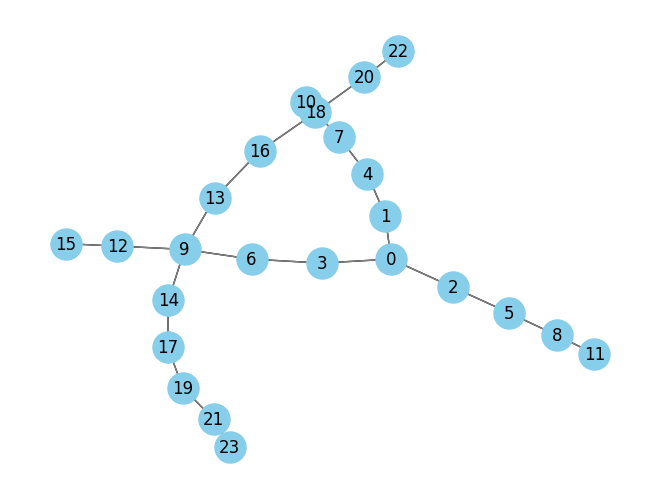

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

edge_list = [
    (0,1),
    (0,2),
    (0,3),
    (1,4),
    (2,5),
    (3,6),
    (4,7),
    (5,8),
    (6,9),
    (7,10),
    (8,11),
    (9,12),
    (9,13),
    (9,14),
    (12,15),
    (13,16),
    (14,17),
    (16,18),
    (17,19),
    (18,20),
    (19,21),
    (20,22),
    (21,23)
]

G = nx.Graph()

G.add_edges_from(edge_list)

layout = nx.spring_layout(G)

nx.draw(G, pos=layout, with_labels=True, node_size=500, node_color='skyblue')

nx.draw_networkx_edges(G, pos=layout, edge_color='gray')

plt.show()


The edge list below represents the connections between the various joints/nodes.

In [ ]:
edge_indices = [
    [0,1],
    [0,2],
    [0,3],
    [1,4],
    [2,5],
    [3,6],
    [4,7],
    [5,8],
    [6,9],
    [7,10],
    [8,11],
    [9,12],
    [9,13],
    [9,14],
    [12,15],
    [13,16],
    [14,17],
    [16,18],
    [17,19],
    [18,20],
    [19,21],
    [20,22],
    [21,23]
]

#adding reverse connections to make it undirected

edge_indices_und = []
for edge in edge_indices:
  edge_indices_und.append([edge[0], edge[1]])
  edge_indices_und.append([edge[1], edge[0]])
edge_indices_und = torch.tensor(edge_indices_und, dtype = torch.long)

We will now convert it to dimensions (2, num of edges) because the graph will take in the connection info in this format

In [ ]:
edge_indices_coo = edge_indices_und.t().contiguous()
print(edge_indices_coo)

tensor([[ 0,  1,  0,  2,  0,  3,  1,  4,  2,  5,  3,  6,  4,  7,  5,  8,  6,  9,
          7, 10,  8, 11,  9, 12,  9, 13,  9, 14, 12, 15, 13, 16, 14, 17, 16, 18,
         17, 19, 18, 20, 19, 21, 20, 22, 21, 23],
        [ 1,  0,  2,  0,  3,  0,  4,  1,  5,  2,  6,  3,  7,  4,  8,  5,  9,  6,
         10,  7, 11,  8, 12,  9, 13,  9, 14,  9, 15, 12, 16, 13, 17, 14, 18, 16,
         19, 17, 20, 18, 21, 19, 22, 20, 23, 21]])


I am now providing my own labels to each node. This has nothing to do with the generation of embeddings but is just to visualize our final embeddings by assigning a colour to different sets of nodes. I want to provide same colours to nearby joints. So, the head and neck will have one class, the arms will be another class, the legs will be a separate class and finally the torso will be a separate class.

In [ ]:
node_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
node_labels = [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,  1,  2,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,  3]
y = torch.tensor(node_labels, dtype = torch.long)

In [ ]:
data = Data(x = frame_data, edge_index = edge_indices_coo, y = y)
data

Data(x=[24, 3], edge_index=[2, 46], y=[24])

In [ ]:
stconvmodel = STConv(24, 3, 3, 3, 1, 2)
trained_features = stconvmodel(total_data, edge_indices_coo)
trained_features2 = stconvmodel(trained_features, edge_indices_coo)
trained_features2[0][0]

tensor([[ 0.4993,  0.9032, -1.3909],
        [ 0.3519,  1.0092, -1.3619],
        [ 0.3511,  1.0015, -1.3607],
        [ 0.3985,  0.9955, -1.3763],
        [ 0.4538,  0.9308, -1.3878],
        [ 0.3998,  0.9714, -1.3742],
        [ 0.4230,  0.9511, -1.3794],
        [ 0.4708,  0.9212, -1.3892],
        [ 0.5008,  0.8925, -1.3963],
        [ 0.6654,  0.7700, -1.4105],
        [ 0.3883,  0.9841, -1.3718],
        [ 0.3880,  0.9837, -1.3716],
        [ 0.3965,  0.9664, -1.3808],
        [ 0.3521,  1.0458, -1.3662],
        [ 0.4084,  0.9548, -1.3751],
        [ 0.3437,  1.0119, -1.3592],
        [ 0.4238,  0.9938, -1.3852],
        [ 0.3689,  0.9838, -1.3649],
        [ 0.3710,  1.0304, -1.3772],
        [ 0.3601,  0.9800, -1.3613],
        [ 0.4318,  0.9795, -1.3690],
        [ 0.5220,  0.8614, -1.4022],
        [ 0.3930,  0.9806, -1.3729],
        [ 0.3867,  0.9842, -1.3712]], grad_fn=<SelectBackward0>)

In [ ]:
total_data[0][0:8]

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

In [ ]:
model = GCN(hidden_channels=6, out_channels = 3)
print(model)

GCN(
  (conv1): GCNConv(3, 6)
  (conv2): GCNConv(6, 3)
)


In [ ]:
out = model(data.x, data.edge_index)
print(out)

tensor([[-0.1585,  0.0212,  0.1389],
        [-0.1223,  0.0358,  0.0593],
        [-0.1156,  0.0390,  0.0515],
        [-0.0861,  0.0102,  0.0609],
        [-0.0315,  0.0075,  0.0201],
        [ 0.0005,  0.0147, -0.0013],
        [ 0.0077, -0.0207,  0.0209],
        [ 0.0095,  0.0040, -0.0250],
        [ 0.0381,  0.0100, -0.0440],
        [ 0.0135, -0.0246,  0.0347],
        [ 0.0077, -0.0068, -0.0045],
        [ 0.0393, -0.0019, -0.0221],
        [ 0.0151,  0.0348, -0.0739],
        [ 0.0624, -0.0268,  0.0498],
        [-0.1521, -0.0294,  0.2498],
        [ 0.0064,  0.0525, -0.0839],
        [ 0.0751, -0.0151,  0.0957],
        [-0.2591, -0.0326,  0.4084],
        [ 0.0670,  0.0331,  0.0586],
        [-0.2792, -0.0446,  0.4425],
        [ 0.0405,  0.0273,  0.0140],
        [-0.1589, -0.0285,  0.2544],
        [ 0.0220,  0.0291, -0.0324],
        [-0.0755, -0.0212,  0.1239]], grad_fn=<AddBackward0>)


In [ ]:
trained_features[0][0].shape

torch.Size([24, 3])

We can use the function below to visualize the final embeddings on a scatter plot. However, this function works only if the dimension of the embeddings of each node is 2. I have later provided another code which uses PCA to visualize embeddings with higher dimensions

In [ ]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

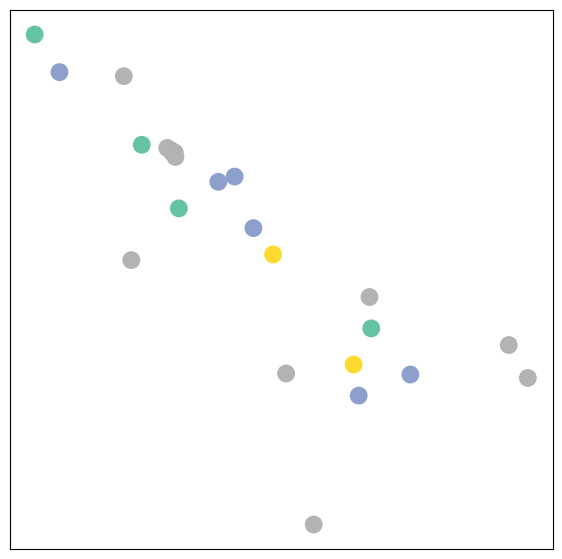

In [ ]:
visualize_embedding(h = trained_features[0][0], color = data.y)

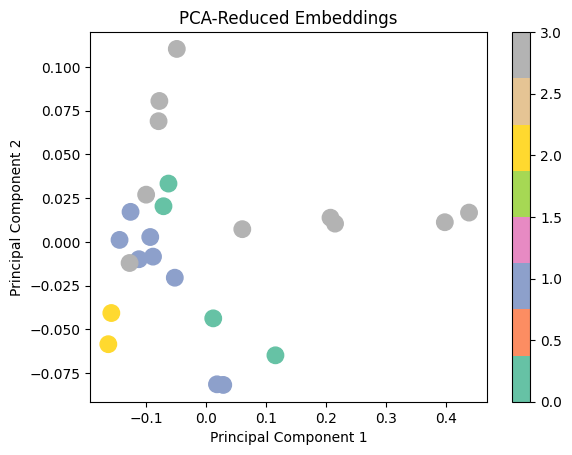

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_h = pca.fit_transform(out.detach().numpy())

plt.scatter(reduced_h[:, 0], reduced_h[:, 1], s=140, c=data.y, cmap="Set2")
plt.title("PCA-Reduced Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()